In [8]:
import pandas as pd
import numpy as np
import os
import math

In [9]:
file_path='./data/10000.xls'
#file_path1='./data/1万土壤数据.xlsx'
data1=pd.read_excel(file_path,sheet_name='中河2')
data2=pd.read_excel(file_path,sheet_name='孤山岭1')
data3=pd.read_excel(file_path,sheet_name='石板沟1')
data4=pd.read_excel(file_path,sheet_name='摩云岭1')
data1.head()

,X,Y,Au,Ag,As,Sb,Bi,Co,Cu,Mo,Ni,Pb,W,Zn
0,382898.8,52224.9,1.10,0.06,27.0,6.31,0.31,13.3,20.6,0.99,22.6,19.9,1.95,58.1
1,382894.8,52224.9,1.85,0.04,28.1,6.52,0.40,14.2,20.3,1.39,25.3,23.3,2.46,69.9
2,382890.8,52224.9,1.82,0.08,25.9,4.16,0.37,15.5,22.1,1.09,29.6,37.1,3.28,63.3
3,382886.8,52224.9,2.26,0.06,26.7,6.24,0.31,15.3,24.3,2.28,31.3,68.4,4.75,73.2
4,382882.8,52224.9,1.22,0.08,26.3,5.22,0.31,14.2,23.0,1.21,29.3,33.4,5.18,76.4


In [10]:
data4.loc[:,['X','Y']].shape

(2645, 2)

In [11]:
data_trian1=pd.concat([data2.loc[:,['Ag','W']],data3.loc[:,['Ag','W']],data4.loc[:,['Ag','W']]]) # 做元素选择
# data_trian1=data4.loc[:,['W']]
# data_trian1=data3.loc[:,['Pb','Zn','Ag']]
data_test1=data1.loc[:,['Ag','W']]
# data_trian=data1.loc[0:int(1989*0.8),['Pb','Zn','Ag']]
# data_test=data1.loc[int(1989*0.8)+1:1989,['Pb','Zn','Ag']]
# data_trian2=data1.loc[:,['Cu']]
# data_test2=data2.loc[:,['Cu']]
location_test=data1.loc[:,['X','Y']]
location_trian=pd.concat([data2.loc[:,['X','Y']],data3.loc[:,['X','Y']],data4.loc[:,['X','Y']]])
# location_trian=data4.loc[:,['X','Y']]
# print(data2.loc[:,['W']].shape)
# print(data3.loc[:,['W']].shape)
print(data_trian1.shape)
print(data_test1.shape)
print()



(5606, 2)
(3925, 2)



In [12]:
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler() #min-max标准化
#scaler = preprocessing.StandardScaler()  #z-score标准化
# data_trian = scaler.fit_transform(data_trian)
# data_test = scaler.fit_transform(data_test)
data_trian1=scaler.fit_transform(data_trian1) 
data_test1=scaler.fit_transform(data_test1) 
# data_trian2=scaler.fit_transform(data_trian2) 
# data_test2=scaler.fit_transform(data_test2) 

In [13]:
#滑动窗口长度；步长
sequence_length = 32#采样点数量
time_step = 8#滑窗步长

In [14]:
#截取滑动窗口的数据
def get_data(start, end, data, location, sequence_length, time_step):
    result = []
    loc=[]
    for index in range(start, end- sequence_length+1 , time_step):
        result.append(np.array(data[index: index + sequence_length])) #.values
        loc.append(np.array(location[index: index + sequence_length]))
    result = np.array(result) #数组
    loc=np.array(loc)
#     np.random.shuffle(result) #打乱顺序
    X_train = result  #[:, :] #训练
    return X_train,loc

In [15]:
def data_dist(location):
    dist=[]
    loc_list=location.values
    for i in range(len(location)):
        tmp=[]
        for j in range(len(location)):
            tmp.append(np.linalg.norm(loc_list[i]-loc_list[j]))
        dist.append(tmp)
    return dist

In [16]:
def get_data1(start, end, data, location, sequence_length, time_step,dist):
    result=[]
    newloc=[]
    loc1=location.values
    for k in range(start,end,time_step):
        tmp=dist[k]
        res=[]
        loc2=[]
        for _ in range(sequence_length):
            idx=dist[k].index(min(tmp))
            res.append(data[idx])
            loc2.append(loc1[idx])
            tmp.remove(min(tmp))
        result.append(res)
        newloc.append(loc2)
    result=np.array(result)
    newloc=np.array(newloc)
    return result,newloc                           

In [17]:
dist_trian=data_dist(location_trian)
dist_test=data_dist(location_test)

In [874]:
X_train,loc_trian = get_data(0, len(data_trian1), data_trian1, location_trian,sequence_length, time_step,dist_trian)

In [875]:
print(X_train.shape)
print(loc_trian.shape)
print(data_trian1.shape)

(697, 32, 2)
(697, 32, 2)
(5606, 2)


In [876]:
import tensorflow as tf 
from keras.models import Model, load_model, Sequential 
from keras.layers import Conv1D, LSTM, Dropout, Dense  
from keras.layers import MaxPooling1D, UpSampling1D, Flatten, Reshape 
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

In [877]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Dense, RepeatVector
from keras.layers.noise import GaussianDropout,GaussianNoise


In [3]:
class Lstm_Autoencoder(object):
    model_name = 'Lstm_Autoencoder'
    VERBOSE = 1

    def __init__(self):
        self.model = None
        self.time_window_size = None
        self.config = None
        self.metric = None
        self.threshold = None
        self.feature_dimentions = None

    @staticmethod
    def create_model(time_window_size, feature_dimentions, metric):
        model = Sequential()
        model.add(GaussianNoise(0.01,input_shape=(time_window_size, feature_dimentions)))
        model.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu',
                        input_shape=(time_window_size, feature_dimentions)))
        model.add(MaxPooling1D(pool_size=2))
        
        model.add(Conv1D(filters=16, kernel_size=3, padding='same', activation='relu',
                        input_shape=(16,32)))
        model.add(MaxPooling1D(pool_size=2))
        
        model.add(Conv1D(filters=8, kernel_size=3, padding='same', activation='relu',
                        input_shape=(8,16)))
        model.add(MaxPooling1D(pool_size=2))    
        
        model.add(UpSampling1D(size=2))
        model.add(Conv1D(filters=8, kernel_size=3, padding='same', activation='relu',
                        input_shape=(8, 8)))

        model.add(UpSampling1D(size=2))
        model.add(Conv1D(filters=16, kernel_size=3, padding='same', activation='relu',
                        input_shape=(16, 8)))
        
        model.add(UpSampling1D(size=2))
        model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu',
                        input_shape=(32, 16)))
        
        model.add(Conv1D(filters=feature_dimentions, kernel_size=5, padding='same', activation='relu',
                        input_shape=(32, 32)))
#        model.add(TimeDistributed(Dense(units=feature_dimentions, activation="linear")))
        
        model.compile(loss="mse", optimizer='adam', metrics=[metric])

        print(model.summary())
        return model
    
  

    def load_model(self, model_dir_path):
        config_file_path = Lstm_Autoencoder.get_config_file(model_dir_path)
        self.config = np.load(config_file_path).item()
        self.metric = self.config['metric']
        self.time_window_size = self.config['time_window_size']
        self.feature_dimentions = self.config['feature_dimentions']
        # self.threshold = self.config['threshold']
        self.model = Lstm_Autoencoder.create_model(self.time_window_size, self.feature_dimentions, self.metric)
        weight_file_path = Lstm_Autoencoder.get_weight_file(model_dir_path)
        self.model.load_weights(weight_file_path)

    @staticmethod
    def get_config_file(model_dir_path):
        return model_dir_path + '/' + Lstm_Autoencoder.model_name + '-config.npy'

    @staticmethod
    def get_weight_file(model_dir_path):
        return model_dir_path + '/' + Lstm_Autoencoder.model_name + '-weights.h5'

    @staticmethod
    def get_architecture_file(model_dir_path):
        return model_dir_path + '/' + Lstm_Autoencoder.model_name + '-architecture.json'

    def fit(self, X_train_data, y_train_data, model_dir_path, batch_size=32, epochs=50,
            validation_split=0.2, metric='mean_absolute_error'):

        self.metric = metric
        self.time_window_size = X_train_data.shape[1]
        self.feature_dimentions = X_train_data.shape[2]

        weight_file_path = Lstm_Autoencoder.get_weight_file(model_dir_path=model_dir_path)
        architecture_file_path = Lstm_Autoencoder.get_architecture_file(model_dir_path)
        early_stopping = EarlyStopping(monitor='val_loss', patience=10) ##5
        checkpoint = ModelCheckpoint(weight_file_path, monitor='val_loss', verbose=1, save_best_only=True)
        callbacks_list = [early_stopping, checkpoint]
        self.model = Lstm_Autoencoder.create_model(self.time_window_size, self.feature_dimentions, metric=self.metric)
        open(architecture_file_path, 'w').write(self.model.to_json())
        history = self.model.fit(x=X_train_data, y=y_train_data,
                                 batch_size=batch_size, epochs=epochs,
                                 verbose=Lstm_Autoencoder.VERBOSE, validation_split=validation_split,
                                 callbacks=callbacks_list)
        self.model.save_weights(weight_file_path)

        # scores = self.predict(X_test_data, y_test_data)
        # scores.sort()
        # cut_point = int(estimated_negative_sample_ratio * len(scores))
        # self.threshold = scores[cut_point]
        #
        # print('estimated threshold is ' + str(self.threshold))

        self.config = dict()
        self.config['time_window_size'] = self.time_window_size
        self.config['feature_dimentions'] = self.feature_dimentions
        self.config['metric'] = self.metric
        # self.config['threshold'] = self.threshold
        config_file_path = Lstm_Autoencoder.get_config_file(model_dir_path=model_dir_path)
        np.save(config_file_path, self.config)

        return history

    def predict_error(self, X_test_data, y_test_data):
        y_test_predict = self.model.predict(x=X_test_data, batch_size=32)
#         dist = np.sum(np.linalg.norm(y_test_data - y_test_predict, axis=2),axis=1)/(y_test_data.shape[1]*y_test_data.shape[2])
        dist=np.linalg.norm(y_test_data - y_test_predict, axis=2)/y_test_data.shape[2]
        return dist

    def anomaly(self, X_test_data, y_test_data, threshold=None):
        if threshold is not None:
            self.threshold = threshold

        dist = self.predict_error(X_test_data, y_test_data)
        return zip(dist >= self.threshold, dist)


In [4]:
DO_TRAINING = True
model_dir_path = './1D_AutoEncoder'
lae = Lstm_Autoencoder()
training_history_file_path = model_dir_path + '/' + lae.model_name + '-trainHistoryDict'
history = None
import pickle
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [5]:
if DO_TRAINING:
    history = lae.fit(X_train, X_train, model_dir_path=model_dir_path, validation_split=0.1, epochs=100)
    with open(training_history_file_path, 'wb') as file_pi:
        pickle.dump(history.history, file_pi)
elif os.path.exists(training_history_file_path):
    with open(training_history_file_path, 'rb') as file_pi:
        history = pickle.load(file_pi)

NameError: name 'X_train' is not defined

In [881]:
X_test,loc_test = get_data(0, len(data_test1), data_test1,location_test, sequence_length, time_step,dist_test)
print(X_test.shape)
print(loc_test.shape)
print(data_test1.shape)

(487, 32, 2)
(487, 32, 2)
(3925, 2)


In [882]:
reconstruction_error_0 = lae.predict_error(X_test, X_test)
reconstruction_error_sum=np.sum(reconstruction_error_0,axis=1)/X_test.shape[1]
print(reconstruction_error_0.shape)
print(reconstruction_error_sum.shape)

(487, 32)
(487,)


In [883]:
def loc_error(reconstruction_error,loc):
    reconstruction={}
    for i in range(loc.shape[0]):
        for j in range(loc.shape[1]):
            lc=tuple(loc[i,j])
            error=reconstruction_error[i,j]
            if lc in reconstruction:
                reconstruction[lc]=max(reconstruction[lc],error)
            else:
                reconstruction[lc]=error
    errors=[]
    for loc,value in reconstruction.items():
        loc=list(loc)
        loc.append(value)
        errors.append(loc)
    errors=np.array(errors)
    return errors    

In [884]:
errors=loc_error(reconstruction_error_0,loc_test)
print(errors.shape)
print(loc_test.shape)

(3920, 3)
(487, 32, 2)


In [887]:
data=pd.DataFrame(errors)
data.columns=['X','Y','error']
with pd.ExcelWriter('out/zhonhe/reconstruction_error_Ag_W.xlsx') as writer:
    data.to_excel(writer,sheet_name='zhonghe_Ag_W') 

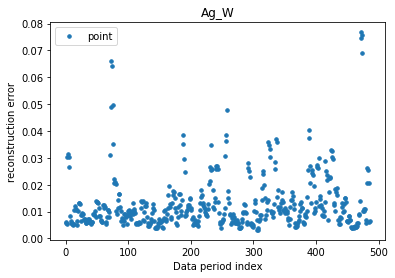

In [888]:
import matplotlib.pyplot as plt
plt.plot(reconstruction_error_sum, marker='o', ms=3.5, linestyle='', label='point')
plt.legend()
plt.title('Ag_W')
plt.ylabel('reconstruction error')
plt.xlabel('Data period index')
plt.savefig('out/zhonhe/zhonghe_Ag_W_reconstruction_error.png')
plt.show()